<a href="https://colab.research.google.com/github/dinachoir/Abstract-Skimmer/blob/main/experiments_abstract_skimmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstract Skimmer**

A replicated deep learning model of [PubMed 200k RCT](https://arxiv.org/abs/1710.06071) paper.

## **Objective**

To explore the ability for NLP models to classify sentences which appear in sequential order, and make an abstract easier to read.

## **Dataset**

The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion.


## **Data Preprocessing**

In [ ]:
# Download the PubMed 200k RCT dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check out the files in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# Define data directory
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Create function to read the lines of the file
def get_lines(filename):
  """
  Objective:
    Reads filename (a text file) and returns the lines of text as list.

  Args:
    filename : a string containing the target filepath to read.
  
  Return:
    A list of strings with one string per line from the target filename.

    Expected return:
    ["First line",
     "Second Line",
      "...", ... "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Get the line of train.txt
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

* Abstracts are separated by abstract's ID starts with ###, and ends with \n
* Each abstract ends with \n
* In an abtract, the class of the sentence is ended with \t
* Each sentence finishes with \n

In [ ]:
# Create a function to preprocess text data

def preprocess_abstract_text(filename):
  """
  Returns a list of dictionaries of lines of an abstract

  Read the filename, extract the lines of each abstract, extract the target label of each line,
  count the sentences in an abstract, and number each line in an abtract.

  Args:
    filename : a string containing the target filepath to read and extract the lines

  Returns:
    A list of dictionaries each containing a line from each abtract,
    The line labels,
    The line position in an abstract,
    The total number of lines in an abstract.
  
  Expected result:
    [{"target": "OBJECTIVE",
      "text": "The aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs neutral mood ) on actual food intake.",
      "line_number": 3,
      "total_lines": 12}, {...}]
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1]
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line

  return abstract_samples


In [ ]:
# Preprocess dataset
train_samples = preprocess_abstract_text(data_dir + "train.txt")
val_samples = preprocess_abstract_text(data_dir + "dev.txt")
test_samples = preprocess_abstract_text(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
# Check out the samples
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 12},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [ ]:
# Turn samples into dataframe
import pandas as pd
train = pd.DataFrame(train_samples)
val = pd.DataFrame(val_samples)
test = pd.DataFrame(test_samples)

train.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12
6,RESULTS,There was a clinically relevant reduction in t...,6,12
7,RESULTS,The mean difference between treatment arms ( @...,7,12
8,RESULTS,"Further , there was a clinically relevant redu...",8,12
9,RESULTS,These differences remained significant at @ we...,9,12


In [ ]:
# Check out the distribution of labels in training set
train["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

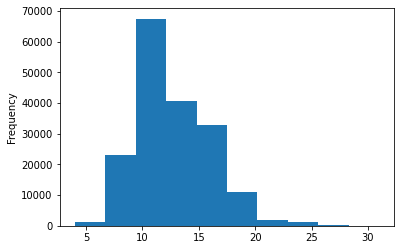

In [ ]:
# Check out the distribution of total_lines in training set
train["total_lines"].plot.hist()

In [ ]:
# Convert abstract text lines into lists
train_sentences = train["text"].tolist()
val_sentences = val["text"].tolist()
test_sentences = test["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the train_sentences
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

**Label Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
train_labels_onehot_encoded = ohe.fit_transform(train["target"].to_numpy().reshape(-1,1))
val_labels_onehot_encoded = ohe.transform(val["target"].to_numpy().reshape(-1,1))
test_labels_onehot_encoded = ohe.transform(test["target"].to_numpy().reshape(-1,1))

# Check encoding
train_labels_onehot_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train["target"].to_numpy().reshape(-1,1))
val_labels_encoded = le.transform(val["target"].to_numpy().reshape(-1,1))
test_labels_encoded = le.transform(test["target"].to_numpy().reshape(-1,1))

# Check encoding
train_labels_encoded

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class name, and number of class
num_class= len(le.classes_)
class_names = le.classes_

num_class , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## **Modeling Experiments:**

In [ ]:
# Load function 
!wget https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py

--2022-08-08 01:20:13--  https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9697 (9.5K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]   9.47K  --.-KB/s    in 0s      

2022-08-08 01:20:14 (73.1 MB/s) - ‘functions.py’ saved [9697/9697]



## **Model 0 : Baseline**

Since we're dealing with text data multi-class classification problem, we're gonna use Multinomial Naive Bayes as baseline model as recommended by [scikit-learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())])

model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Make prediction on validation set
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Evaluate prediction
from functions import evaluate_prediction

model_0_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_0_preds)

## **Model 1 : Conv1D with Token Embeddings**

### **Creating Text Vectorization**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Find the average length of sentences (number of words) in training set
sentence_length = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_length = np.mean(sentence_length)
avg_sentence_length

26.338269273494777

In [ ]:
# Find the maximum length of sentences
max(sentence_length)

296

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <a list of 10 Patch objects>)

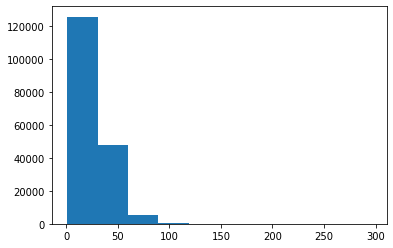

In [ ]:
# Check the distribution of sentence length
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=10)

In [ ]:
# Check length of sentence that covers 95% of all sentences in training set
perc_95_sentence_length = int(np.percentile(sentence_length, 95))
perc_95_sentence_length

55

The majority of sentences are between 0 and 50 tokens in length. However, 95% of sentences in training set have a length of 55 tokens or less. Using 95% of sencentes because it already covered the majority of the infomation, and to avoid too long token since the maximum of length is 296.

In order to create tokenization layer, the length of sentences must be the same. To do so, sentences with length below 55 will get padded with zeros. Meanwhile, the sentence with length above 55 will get truncated/cut off.

Refers to section 3.2 of PubMed paper, PubMed 20k dataset contains 68,000 unique words in the vocabulary. 

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=perc_95_sentence_length)

# Adapt text vectorizer to training set
text_vectorizer.adapt(train_sentences)

In [ ]:
# View vectorized text
import random
sample_sentence = random.choice(train_sentences)
print(f"Sentence:\n{sample_sentence}")
print(f"\nLength of sentence: {len(sample_sentence.split())}")
print(f"\nVectorized sentence:\n{text_vectorizer([sample_sentence])}")

Sentence:
When group @ was compared with group @ in histopathologic sections , axonolysis was less in group @ ( p = @ ) , as was axon degeneration ( p = @ ) and edema ( p = @ ) .

Length of sentence: 41

Vectorized sentence:
[[  183    13    10    34     7    13     5  7866  4862 32522    10   211
      5    13    14    25    10 32523  2957    14     3  1729    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Count unique words in training set
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of unique words in the vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of unique words in the vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text_vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### **Creating Text Embedding**

Text embedding 

In [ ]:
# Create embedding layer
token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim=128, # the larger embedding size the more parameters the model has to train, it could take longer
                                                  # the smaller embedding size may not capture as much information as the larger one
                                   mask_zero=True, # help tf to do more efficient computing when there's alot zeros
                                   name="token_embedding")

In [ ]:
# View embedded sentence
print(f"Sentence before vectorization:\n{sample_sentence}\n")
vectorized_sentence = text_vectorizer([sample_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
When group @ was compared with group @ in histopathologic sections , axonolysis was less in group @ ( p = @ ) , as was axon degeneration ( p = @ ) and edema ( p = @ ) .

Sentence after vectorization (before embedding):
[[  183    13    10    34     7    13     5  7866  4862 32522    10   211
      5    13    14    25    10 32523  2957    14     3  1729    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.02787051  0.01301887 -0.02929273 ...  0.01791804  0.01813331
   -0.02810538]
  [ 0.03814225  0.00086797  0.02468297 ... -0.01822313  0.00169407
    0.02770591]
  [ 0.0045483   0.01075632 -0.00489793 ...  0.00445728 -0.04557483
    0.00683255]
  ...
  [ 0.00405129  0.00473619  0.04199416 ...  0.04419342 -0.0417765
    0.00657693]
  [ 0.00405129  0.00473619  0.04199416 ...  

### **Batching and Prefetching**

Prefetching make dataset more efficient to load.

In [ ]:
# Turn dataset into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot_encoded))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Turn TensorSliceDatasets into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### **Modeling**

In [ ]:
# Create 1D Convolutional model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_class, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 77s 135ms/step - loss: 0.9084 - accuracy: 0.6389 - val_loss: 0.6820 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.6581 - accuracy: 0.7567 - val_loss: 0.6264 - val_accuracy: 0.7729
Epoch 3/3
562/562 [==============================] - 60s 106ms/step - loss: 0.6193 - accuracy: 0.7752 - val_loss: 0.5961 - val_accuracy: 0.7849


In [ ]:
# Evaluate model on the whole validation set
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5985 - accuracy: 0.7861


[0.5985413193702698, 0.7860783934593201]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.2607859e-01, 1.9472386e-01, 9.1968440e-02, 2.5628489e-01,
        3.0944217e-02],
       [4.5092320e-01, 2.7433747e-01, 1.3341645e-02, 2.5356928e-01,
        7.8284340e-03],
       [1.5801108e-01, 6.9232015e-03, 1.4115231e-03, 8.3361518e-01,
        3.8981358e-05],
       ...,
       [3.2569083e-06, 8.2262303e-04, 4.5839953e-04, 1.3676423e-06,
        9.9871433e-01],
       [4.8156440e-02, 4.2834616e-01, 1.0422418e-01, 5.8521915e-02,
        3.6075130e-01],
       [1.7521752e-01, 6.7075801e-01, 4.0376246e-02, 4.2294696e-02,
        7.1353555e-02]], dtype=float32)

In [ ]:
# Get the predicted class based on prediction probability
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Model evaluation metrics
model_1_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_1_preds)
model_1_evaluation

{'accuracy': 78.60783794518734,
 'f1': 0.783569709265821,
 'precision': 0.7825759303759962,
 'recall': 0.7860783794518734}

## **Model 2 : Feature Extraction with Pretrained Token Embeddings**

In [ ]:
# Download TF-Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out tf_hub_embedding_layer on sample_sentence
print(f"Sentence before embedding:\n{sample_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([sample_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Embedded sentence shape: {use_embedded_sentence.shape}")

Sentence before embedding:
When group @ was compared with group @ in histopathologic sections , axonolysis was less in group @ ( p = @ ) , as was axon degeneration ( p = @ ) and edema ( p = @ ) .

Sentence after embedding:
[[-1.99143346e-02 -5.95317855e-02  7.38745332e-02 -3.60306501e-02
  -9.25567374e-03  1.33382101e-02  5.10349385e-02 -6.53192028e-02
  -7.48136127e-03  2.16995291e-02  7.86151290e-02  6.04864508e-02
   5.01015075e-02  5.80581389e-02 -1.14675099e-02 -6.59532547e-02
  -4.72677574e-02 -1.20633664e-02  6.93585947e-02 -2.71524210e-02
   5.95351867e-02  7.57184951e-03 -6.90739825e-02 -7.20369741e-02
   3.21789943e-02  5.34953624e-02 -9.99257993e-03  5.35394512e-02
  -5.63145839e-02  8.99681915e-03  5.57355098e-02  7.91179910e-02
  -3.67185250e-02 -4.92487438e-02 -2.75403988e-02 -2.35546473e-02
   6.36138692e-02  1.43170338e-02 -1.14875555e-03 -6.06317334e-02
   2.40424350e-02  2.70077270e-02  5.97089455e-02  4.22598459e-02
   2.72695292e-02  2.33487580e-02  6.50486201e-02 -

In [ ]:
# Create the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(num_class, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Model summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9182 - accuracy: 0.6494 - val_loss: 0.7936 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7667 - accuracy: 0.7043 - val_loss: 0.7507 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7493 - accuracy: 0.7140 - val_loss: 0.7346 - val_accuracy: 0.7158


In [ ]:
# Evaluate model on the whole validation set
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7377 - accuracy: 0.7161


[0.737736165523529, 0.7161392569541931]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1705045e-01, 3.7408736e-01, 2.8236245e-03, 1.9684075e-01,
        9.1977855e-03],
       [3.5175472e-01, 4.8611891e-01, 3.4197744e-03, 1.5624085e-01,
        2.4656188e-03],
       [2.3343615e-01, 1.6250089e-01, 2.4981119e-02, 5.4142439e-01,
        3.7657447e-02],
       ...,
       [1.6557171e-03, 6.7055938e-03, 4.6988036e-02, 7.3707459e-04,
        9.4391358e-01],
       [3.8743748e-03, 4.6967685e-02, 2.0066839e-01, 1.4348455e-03,
        7.4705464e-01],
       [1.8532546e-01, 2.9926613e-01, 4.3987104e-01, 7.7643739e-03,
        6.7772999e-02]], dtype=float32)

In [ ]:
# Get the predicted class
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Model evaluation
model_2_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_2_preds)
model_2_evaluation

{'accuracy': 71.61392824043426,
 'f1': 0.7131573371254903,
 'precision': 0.7164379737219094,
 'recall': 0.7161392824043427}

## **Model 3 : Conv1D with Character Embeddings**

Character Embeddings split sequences into characters and creates a feature vectore for each.

### **Character-level Splitting**

In [ ]:
# Split sentences into characters
def split_characters(text):
  return " ".join(list(text))

# Test out the function
split_characters(sample_sentence)

'W h e n   g r o u p   @   w a s   c o m p a r e d   w i t h   g r o u p   @   i n   h i s t o p a t h o l o g i c   s e c t i o n s   ,   a x o n o l y s i s   w a s   l e s s   i n   g r o u p   @   (   p   =   @   )   ,   a s   w a s   a x o n   d e g e n e r a t i o n   (   p   =   @   )   a n d   e d e m a   (   p   =   @   )   .'

In [ ]:
# Split datasets into character-level splits
train_chars = [split_characters(sentence) for sentence in train_sentences]
val_chars = [split_characters(sentence) for sentence in val_sentences]
test_chars = [split_characters(sentence) for sentence in test_sentences]

# check out splitting result
print(train_chars[0])

T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .


In [ ]:
# Find the average character length in train_sentences
char_lengths = [len(sentence) for sentence in train_sentences]
avg_char_length = np.mean(char_lengths)
avg_char_length

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

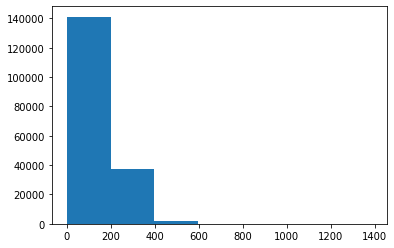

In [ ]:
# Check the distribution of character length
plt.hist(char_lengths, bins=7)

In [ ]:
# Check length of character that covers 95% of all sentences in training set
perc_95_character_length = int(np.percentile(char_lengths, 95))
perc_95_character_length

290

In [ ]:
# Get all keyboard characters
import string
chars = string.ascii_lowercase + string.digits + string.punctuation
chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
len(chars)

68

### **Creating Character-level Vectorization**

In [ ]:
# Create character vectorizer 
num_char_tokens = len(chars)
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length=perc_95_character_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="character_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of unique characters in the vocabulary: {len(char_vocab)}")
print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

Number of unique characters in the vocabulary: 28
Most common characters in the vocabulary: ['', '[UNK]', 'e', 't', 'i']
Least common characters in the vocabulary: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer on sample character
sample_chars = random.choice(train_chars)
print(f"Sample characters:\n{sample_chars}")
print(f"\nLength of characters: {len(sample_chars.split())}")

vectorized_chars = char_vectorizer([sample_chars])
print(f"Vectorized characters:\n{vectorized_chars}")
print(f"\nLength of vectorized characters: {len(vectorized_chars[0])}")

Sample characters:
D a y s   a l i v e   a n d   v e n t i l a t o r   f r e e   a t   @   d a y s   w a s   g r e a t e r   i n   t h e   i N O   g r o u p   ,   @   @   a n d   @   @   d a y s   (   i N O   a n d   p l a c e b o   g r o u p s   ,   r e s p e c t i v e l y   ,   P   =   @   )   .

Length of characters: 107
Vectorized characters:
[[10  5 19  9  5 12  4 21  2  5  6 10 21  2  6  3  4 12  5  3  7  8 17  8
   2  2  5  3 10  5 19  9 20  5  9 18  8  2  5  3  2  8  4  6  3 13  2  4
   6  7 18  8  7 16 14  5  6 10 10  5 19  9  4  6  7  5  6 10 14 12  5 11
   2 22  7 18  8  7 16 14  9  8  2  9 14  2 11  3  4 21  2 12 19 14  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### **Creating Character-level Embedding**

In [ ]:
# Create character embedding layer
char_embedding = layers.Embedding(input_dim=num_char_tokens,
                                    output_dim=25, # embedding dimension of each character
                                    mask_zero=False,
                                    name="char_embedding")

In [ ]:
# Test out character embedding layer
char_embedded_sentence = char_embedding(vectorized_chars)
print(f"Sentence after embedding:\n{char_embedded_sentence}\n")
print(f"Embedded sentence shape: {char_embedded_sentence.shape}")

Sentence after embedding:
[[[ 0.00761487  0.03958644 -0.02907908 ... -0.00146793  0.01140912
    0.04129891]
  [ 0.00085323  0.01073151  0.01441387 ... -0.02101207  0.04292948
    0.01580394]
  [ 0.04728525 -0.01480345 -0.01961997 ...  0.02809635  0.03155123
   -0.0256887 ]
  ...
  [-0.00699087  0.02451592  0.03288286 ... -0.02584999 -0.03590242
    0.02786257]
  [-0.00699087  0.02451592  0.03288286 ... -0.02584999 -0.03590242
    0.02786257]
  [-0.00699087  0.02451592  0.03288286 ... -0.02584999 -0.03590242
    0.02786257]]]

Embedded sentence shape: (1, 290, 25)


### **Batching and Prefetching**

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### **Modeling**

In [ ]:
# Create 1D convolutional model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_class, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Model summary
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 character_vectorizer (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1700      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 5

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 27ms/step - loss: 1.4579 - accuracy: 0.3481 - val_loss: 1.4035 - val_accuracy: 0.4013
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 1.3735 - accuracy: 0.4148 - val_loss: 1.3458 - val_accuracy: 0.4318
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 1.3359 - accuracy: 0.4443 - val_loss: 1.3179 - val_accuracy: 0.4468


In [ ]:
# Evaluate model on the whole validation set
model_3.evaluate(valid_char_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 1.3176 - accuracy: 0.4471


[1.3176419734954834, 0.4470739960670471]

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

array([[0.1561801 , 0.22892797, 0.25545466, 0.1831109 , 0.17632635],
       [0.11940873, 0.16995327, 0.16230051, 0.06490213, 0.4834353 ],
       [0.09719288, 0.1554805 , 0.40759578, 0.10334687, 0.23638405],
       ...,
       [0.07279513, 0.11980815, 0.24176836, 0.04084985, 0.52477854],
       [0.05697533, 0.11470538, 0.22406028, 0.04191176, 0.56234723],
       [0.14301361, 0.17730325, 0.19088282, 0.07300299, 0.41579732]],
      dtype=float32)

In [ ]:
# Get the predicted class based on prediction probability
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [ ]:
# Model evaluation metrics
model_3_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_3_preds)
model_3_evaluation

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.707401032702236,
 'f1': 0.39206037210943295,
 'precision': 0.37764643698646383,
 'recall': 0.4470740103270224}

## **Model 4 : Hybrid Embedding Layer**

Hybrid Embedding Layer is a combination of pretrained token embeddings and character embeddings. This model requires 2 inputs: token_level sequences and character-level sequences. 

**Modeling Setup:**
1. Create a token-level model
2. Create a character-level model
3. Combine the output of (1) and (2) using Concatenate
4. Construct a model which takes token and character-level sequences as input and produce sequence label probabilities as output
5. Train on 10% of training batches, and validate on 10% of validation batches

### **Batching and Prefetching**

In [ ]:
# Combine tokens and chars into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot_encoded)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot_encoded)
valid_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

# Prefetch and batch
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_token_char_dataset = valid_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out token and char embedding dataset
train_token_char_dataset, valid_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### **Modeling**

In [ ]:
# Setup token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Create hybrid token embedding (Concatenate token and char inputs)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# Create output layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
combined_dropout_2 = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_class, activation="softmax")(combined_dropout_2)

# Construct a model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_hybrid_embeddings")

In [ ]:
# Model summary
model_4.summary()

Model: "model_4_hybrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

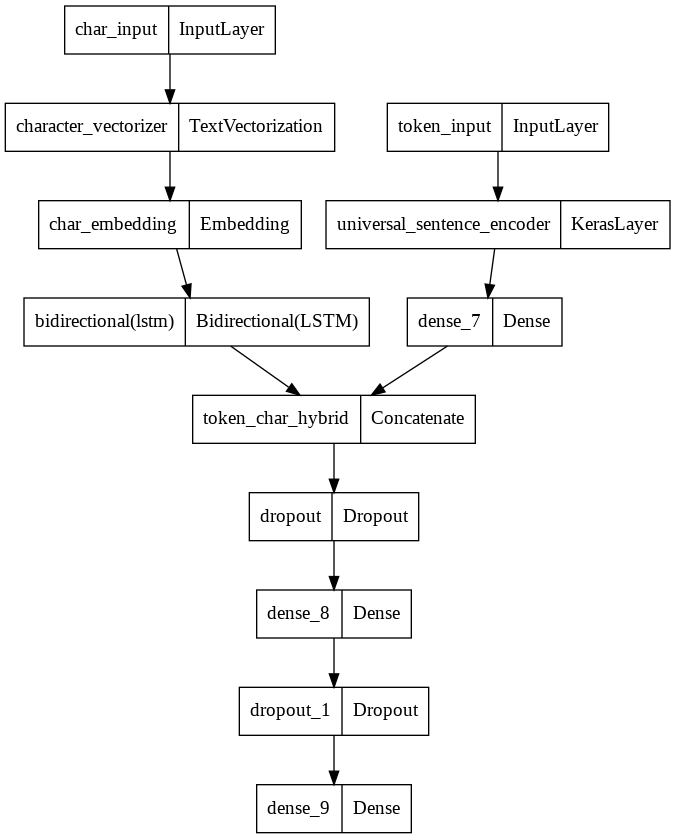

In [ ]:
# Plot the architecture of the model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=valid_token_char_dataset,
                              validation_steps=int(0.1*len(valid_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 133s 229ms/step - loss: 0.9710 - accuracy: 0.6137 - val_loss: 0.7809 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 125s 223ms/step - loss: 0.7997 - accuracy: 0.6863 - val_loss: 0.7150 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 117s 209ms/step - loss: 0.7713 - accuracy: 0.7055 - val_loss: 0.6978 - val_accuracy: 0.7357


In [ ]:
# Evaluate model on the whole validation set
model_4.evaluate(valid_token_char_dataset)

945/945 [==============================] - 44s 47ms/step - loss: 0.7021 - accuracy: 0.7321


[0.7021132707595825, 0.7320601344108582]

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(valid_token_char_dataset)
model_4_pred_probs

array([[3.91268075e-01, 4.00271833e-01, 3.58367898e-03, 1.98549077e-01,
        6.32732781e-03],
       [2.86866277e-01, 3.73185605e-01, 2.88799591e-03, 3.35832834e-01,
        1.22733437e-03],
       [3.24289978e-01, 8.05180892e-02, 3.38052623e-02, 5.43156564e-01,
        1.82300154e-02],
       ...,
       [7.10254128e-04, 1.17254937e-02, 4.63953875e-02, 3.49421491e-04,
        9.40819502e-01],
       [9.09419451e-03, 6.64123818e-02, 1.84975877e-01, 4.78830654e-03,
        7.34729230e-01],
       [2.54524976e-01, 5.40807605e-01, 1.59121111e-01, 1.41559085e-02,
        3.13904919e-02]], dtype=float32)

In [ ]:
# Get the predicted class based on prediction probability
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Model evaluation metrics
model_4_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_4_preds)
model_4_evaluation

{'accuracy': 73.20601085661326,
 'f1': 0.7300565837052242,
 'precision': 0.7353628680960914,
 'recall': 0.7320601085661327}

## **Model 5 : Tribrid Embedding Layer**

Combining transfer learning with pretrained token embeddings, character embeddings, and positional embeddings.

Since abstracts typically have a sequential order (objective - methods - results - conclusion), it makes sense to add the line number of where a particular sentence occurs to a model.

**Modeling Setup:**
1. Create a token-level model
2. Create a character-level model
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

### **Creating Positional Embeddings**

In [ ]:
# Count line_number of training set
train["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

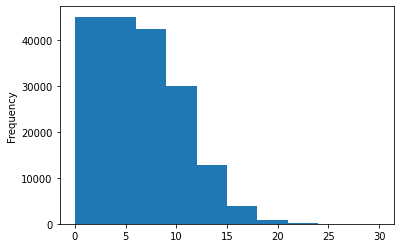

In [ ]:
# Check the distribution of line_number
train["line_number"].plot.hist()

The majority of lines have a position of 15 or less. Then set the depth parameter of tf.one_hot to 15. Any sample with a line_number value 

In [ ]:
# One-hot encode line_number column
train_line_number_onehot_encoded = tf.one_hot(train["line_number"].to_numpy(), depth=15)
val_line_number_onehot_encoded = tf.one_hot(val["line_number"].to_numpy(), depth=15)
test_line_number_onehot_encoded = tf.one_hot(test["line_number"].to_numpy(), depth=15)

In [ ]:
# Check one hot encoding
train_line_number_onehot_encoded.shape, train_line_number_onehot_encoded[:5]

(TensorShape([180040, 15]), <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [ ]:
# Count total_lines of training set
train["total_lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

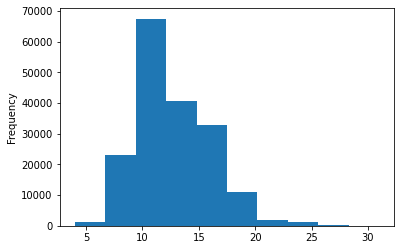

In [ ]:
# Check the distribution of total_lines
train["total_lines"].plot.hist()

Total lines 20 covers the majority of samples, so set the depth parameter of tf.one_hot to 20.

In [ ]:
# One-hot encode total_lines column
train_total_lines_onehot_encoded = tf.one_hot(train["total_lines"].to_numpy(), depth=20)
val_total_lines_onehot_encoded = tf.one_hot(val["total_lines"].to_numpy(), depth=20)
test_total_lines_onehot_encoded = tf.one_hot(test["total_lines"].to_numpy(), depth=20)

### **Batching and Prefetching**

In [ ]:
# Combine tokens and chars into a dataset
train_pos_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_number_onehot_encoded,
                                                                train_total_lines_onehot_encoded,
                                                                train_sentences, 
                                                                train_chars))
train_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot_encoded)
train_pos_token_char_dataset = tf.data.Dataset.zip((train_pos_token_char_data, train_pos_token_char_labels))

val_pos_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_onehot_encoded,
                                                          val_total_lines_onehot_encoded,
                                                          val_sentences, 
                                                          val_chars))
val_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot_encoded)
valid_pos_token_char_dataset = tf.data.Dataset.zip((val_pos_token_char_data, val_pos_token_char_labels))

# Prefetch and batch
train_pos_token_char_dataset = train_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_pos_token_char_dataset = valid_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out pos_token_char embedding dataset
train_pos_token_char_dataset, valid_pos_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### **Modeling**

In [ ]:
# Setup token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Setup char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Setup line_number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# Setup total_lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# Create hybrid token embedding (Concatenate token and char inputs)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)

# Combine hybrid token embeddings with positional embeddings (Tribrid embeddings)
token_char_pos_concat = layers.Concatenate(name="token_char_pos_tribrid")([line_number_model.output, 
                                                                           total_lines_model.output,
                                                                           z])

# Create output layer
output_layer = layers.Dense(num_class, activation="softmax")(token_char_pos_concat)

# Construct a model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input, 
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embeddings")

In [ ]:
# Model summary
model_5.summary()

Model: "model_5_tribrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_

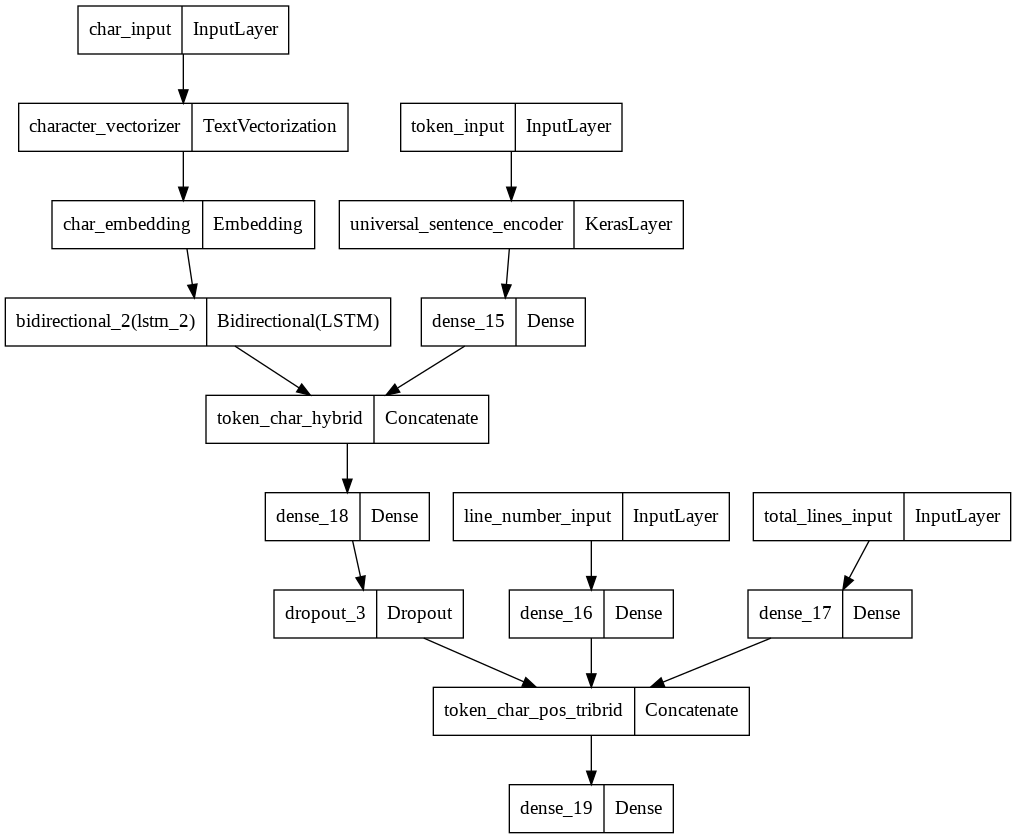

In [ ]:
# Plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Check the trainable layers
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdfe2f5fe90> True
<keras.engine.input_layer.InputLayer object at 0x7fdfe30a4e10> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fdfe645abd0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fdfedc02310> False
<keras.layers.embeddings.Embedding object at 0x7fdfe645a410> True
<keras.layers.core.dense.Dense object at 0x7fdfe30a4b10> True
<keras.layers.wrappers.Bidirectional object at 0x7fdfe2f66c90> True
<keras.layers.merge.Concatenate object at 0x7fdfe2e33750> True
<keras.engine.input_layer.InputLayer object at 0x7fdfe2fb2550> True
<keras.engine.input_layer.InputLayer object at 0x7fdfe2e609d0> True
<keras.layers.core.dense.Dense object at 0x7fdfe2e36f50> True
<keras.layers.core.dense.Dense object at 0x7fdfe2fc7dd0> True
<keras.layers.core.dense.Dense object at 0x7fdfe2e36ad0> True
<keras.layers.core.dropout.Dropout object at 0x7fdfe2e3bb50> True
<keras.layers.merge.Concatenate object at 0x7fdfe2

In [ ]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_pos_token_char_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_token_char_dataset)),
                              epochs=3,
                              validation_data=valid_pos_token_char_dataset,
                              validation_steps=int(0.1*len(valid_pos_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 136s 231ms/step - loss: 1.0961 - accuracy: 0.7243 - val_loss: 0.9850 - val_accuracy: 0.8078
Epoch 2/3
562/562 [==============================] - 130s 232ms/step - loss: 0.9687 - accuracy: 0.8129 - val_loss: 0.9517 - val_accuracy: 0.8258
Epoch 3/3
562/562 [==============================] - 135s 240ms/step - loss: 0.9509 - accuracy: 0.8200 - val_loss: 0.9420 - val_accuracy: 0.8275


In [ ]:
# Evaluate model on the whole validation set
model_5.evaluate(valid_pos_token_char_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.9400 - accuracy: 0.8295


[0.9400115609169006, 0.8294717073440552]

In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(valid_pos_token_char_dataset)
model_5_pred_probs

array([[0.48177144, 0.12434062, 0.01066346, 0.36801478, 0.01520972],
       [0.4950356 , 0.11244622, 0.04129551, 0.34178367, 0.00943894],
       [0.27123502, 0.11849134, 0.12638125, 0.4207718 , 0.06312056],
       ...,
       [0.03450767, 0.07630643, 0.03437851, 0.03112959, 0.8236778 ],
       [0.02770745, 0.2908125 , 0.08534416, 0.02482756, 0.5713084 ],
       [0.26793316, 0.5423305 , 0.0890108 , 0.04532741, 0.05539814]],
      dtype=float32)

In [ ]:
# Get the predicted class based on prediction probability
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Model evaluation metrics
model_5_evaluation = evaluate_prediction(val_labels_encoded,
                                         model_5_preds)
model_5_evaluation

{'accuracy': 82.9471733086191,
 'f1': 0.8287751794227022,
 'precision': 0.8284318382317034,
 'recall': 0.8294717330861909}

## **Compare Models**

In [ ]:
model_evaluations = pd.DataFrame({"baseline":model_0_evaluation,
                                  "conv1d_token_embedding":model_1_evaluation,
                                  "pretrained_token_embedding":model_2_evaluation,
                                  "conv1d_character_embedding":model_3_evaluation,
                                  "hybrid_embedding":model_4_evaluation,
                                  "tribrid_embedding":model_5_evaluation}).T

model_evaluations

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
conv1d_token_embedding,78.607838,0.782576,0.786078,0.783570
pretrained_token_embedding,71.613928,0.716438,0.716139,0.713157
conv1d_character_embedding,44.707401,0.377646,0.447074,0.392060
hybrid_embedding,73.206011,0.735363,0.732060,0.730057
tribrid_embedding,82.947173,0.828432,0.829472,0.828775


In [ ]:
# Scale the accuracy values
model_evaluations["accuracy"] = model_evaluations["accuracy"]/100

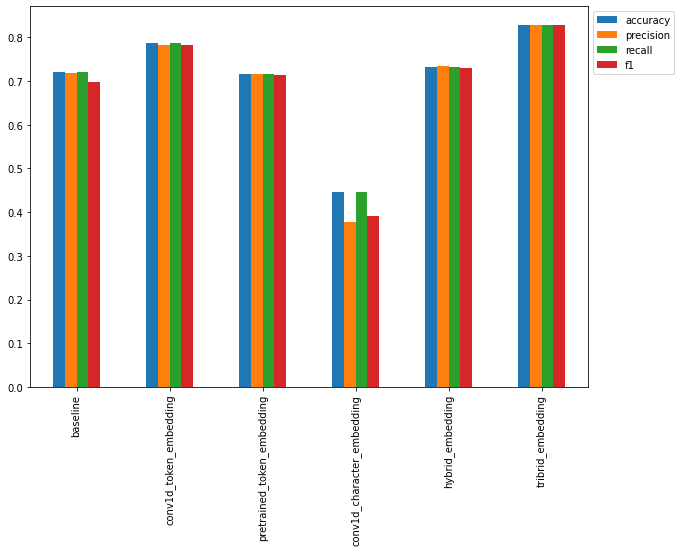

In [ ]:
# Plot model evaluation metrics
model_evaluations.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1,1))

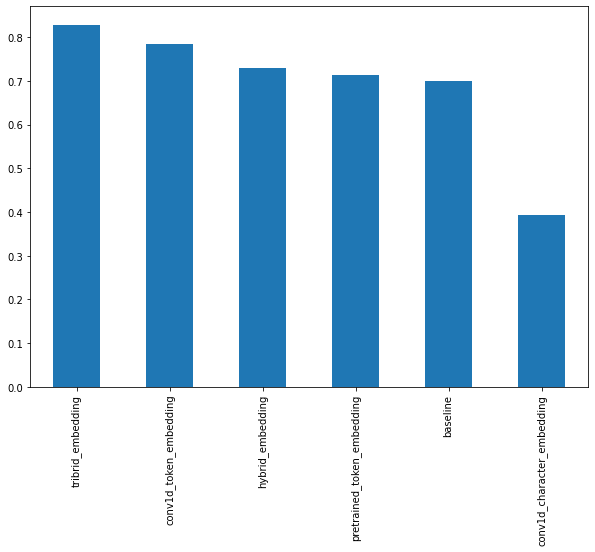

In [ ]:
# Sort model evaluation by f1-score metric
model_evaluations.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
# Save Fine tuned TF Hub Sentence Encoder model to HDF5 format
#model_5.save("model_6.h5")

## **Evaluate Model on Testing Set**

**Batching and Prefetching**

In [ ]:
# Combine tokens and chars into a dataset
test_pos_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_number_onehot_encoded,
                                                               test_total_lines_onehot_encoded,
                                                               test_sentences, 
                                                               test_chars))
test_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot_encoded)
test_pos_token_char_dataset = tf.data.Dataset.zip((test_pos_token_char_data, test_pos_token_char_labels))

# Prefetch and batch
test_pos_token_char_dataset = test_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**Predictions**

In [ ]:
# Make predictions
test_pred_probs = model_5.predict(test_pos_token_char_dataset, verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 65s 69ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Model evaluation metrics
model_5_test_evaluation = evaluate_prediction(test_labels_encoded,
                                              test_preds)
model_5_test_evaluation

{'accuracy': 82.58171561307451,
 'f1': 0.8250187631062073,
 'precision': 0.8246765347654068,
 'recall': 0.825817156130745}

**Investigate The Wrong Predictions**

The most wrong predictions are test data where the model has made a prediction with a high probability but has gotten it wrong predicted label (not the same with ground truth label). By investigating this, it can give valuable information on how to improve the model further.

In [ ]:
%%time
# Convert integer-based test predictions into string-based class names in a list
## le = LabelEncoder()
test_preds_classes = [le.classes_[pred] for pred in test_preds]
test_preds_classes

CPU times: user 10.3 s, sys: 28.1 ms, total: 10.3 s
Wall time: 11.7 s


In [ ]:
# Add the prediction result to the dataframe
## column of prediction class names
test["prediction"] = test_preds_classes
## column of the maximum prediction probability
test["pred_probs"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
## column of correctness
test["correct"] = test["prediction"] == test["target"]

test.head(3)

,target,text,line_number,total_lines,prediction,pred_probs,correct
0,BACKGROUND,This study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.528897,False
1,RESULTS,A post hoc analysis was conducted with the use...,1,9,OBJECTIVE,0.397841,False
2,RESULTS,Liver function tests ( LFTs ) were measured at...,2,9,METHODS,0.788900,False


In [ ]:
# Find the most wrong predictions
most_wrongs = test[test["correct"] == False].sort_values("pred_probs", ascending=False)[:100]
most_wrongs.head()

,target,text,line_number,total_lines,prediction,pred_probs,correct
16347,BACKGROUND,To evaluate the effects of the lactic acid bac...,0,13,OBJECTIVE,0.937484,False
2388,RESULTS,The primary endpoint is the cumulative three-y...,4,14,METHODS,0.933880,False
3573,RESULTS,A cluster randomised trial was implemented wit...,3,17,METHODS,0.923850,False
8545,METHODS,Pretest-posttest .,1,12,BACKGROUND,0.922371,False
13598,METHODS,-@ % vs. Fish : -@ % vs. Fish + S : -@ % ; p <...,6,10,RESULTS,0.921202,False


In [ ]:
# Check out the most wrong predictions
for row in most_wrongs[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_probs, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_probs}, Line number: {line_number}, Total lines: {total_lines}")
  print(f"Text:\n{text}\n")
  print("------\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9374840259552002, Line number: 0, Total lines: 13
Text:
To evaluate the effects of the lactic acid bacterium Lactobacillus salivarius on caries risk factors .

------

Target: RESULTS, Pred: METHODS, Prob: 0.9338799118995667, Line number: 4, Total lines: 14
Text:
The primary endpoint is the cumulative three-year HIV incidence .

------

Target: RESULTS, Pred: METHODS, Prob: 0.9238497018814087, Line number: 3, Total lines: 17
Text:
A cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of Kenya in @-@ .

------

Target: METHODS, Pred: BACKGROUND, Prob: 0.9223708510398865, Line number: 1, Total lines: 12
Text:
Pretest-posttest .

------

Target: METHODS, Pred: RESULTS, Prob: 0.9212024807929993, Line number: 6, Total lines: 10
Text:
-@ % vs. Fish : -@ % vs. Fish + S : -@ % ; p < @ ) but there were no significant differences between groups .

------

Target: CONCLUSIONS, Pred: METHODS, Pro

## **Predict on Unseen Data**

In [ ]:
# Create a set of abstracts

new_abstracts = [{"abstract" : "Social skills training (SST) for autism spectrum disorder (ASD) has traditionally focused on face-to-face (F2F-SST) interventions. Recently, Behavioral Intervention Technologies (BITs-SST) have been utilized to target social skills deficits using computer-based programs, avatars, and therapeutic robots. The present meta-analysis reviews recent evidence and compares the efficacy of 14 F2F-SST and four identified BITs-SST intervention trials for youth with ASD. These preliminary analyses did not indicate significant differences between F2F-SST and BITs-SST, with effect sizes consistently in the medium to high range (g = 0.81 and g = 0.93, respectively). These findings provide initial support for the continued investigation of BITs for providing SST to youth with ASD.",
                  "source" : "https://pubmed.ncbi.nlm.nih.gov/33225056/",
                  "details" : "Social Skills Training for Autism Spectrum Disorder: a Meta-analysis of In-person and Technological Interventions"},
                 {"abstract" : "Given high rates of co-occurring conditions in youth and adults with autism spectrum disorder (ASD), it is critical to examine the developmental trajectories of these symptoms of psychopathology. Using data from a cohort of participants (n = 194), most of whom were first assessed for ASD in very early childhood, we investigated the trajectories of co-occurring depressive, anxiety, and attention-deficit hyperactivity disorder (ADHD) symptoms from late childhood to adulthood. Additionally, childhood predictors and adult outcomes associated with these symptom trajectories were examined. Using group-based trajectory modeling, we found two distinct classes of individuals exhibiting each of these co-occurring symptom patterns: one class exhibited fairly low symptoms across time, and one class with elevated symptoms with varied fluctuation across time (ADHD symptoms starting high but decreasing, anxiety symptoms high and stable, and depressive symptoms fluctuating but peaking at clinically significant levels in young adulthood). All high trajectory classes were associated with age 9 adaptive skills; verbal IQ predicted higher anxiety and depressive symptom classes. After accounting for verbal IQ, all high symptom trajectory classes were negative predictors of objective adult outcomes. These findings call for wide-ranging considerations of the needs of individuals across ability levels, autism symptoms, and behavioral and emotional challenges.",
                  "source" : "https://pubmed.ncbi.nlm.nih.gov/32677592/",
                  "details" : "Trajectories of co-occurring psychopathology symptoms in autism from late childhood to adulthood"},
                 {"abstract" : "Significant advancements have been made in early intervention programs for children with Autism spectrum disorder (ASD). However, measuring treatment response for children with ASD is difficult due to the heterogeneity of changes in symptoms, which can be subtle, especially over a short period of time. Here we outline the challenge of evaluating treatment response with currently available measures as well as newly developed or refined measures that may be useful in clinical trials for young children with ASD. Continued development of treatment outcome measures will help the field identify and compare efficacious interventions and tailor treatments for children with ASD.",
                  "source" : "https://pubmed.ncbi.nlm.nih.gov/32446440/",
                  "details" : "Recent Developments in Treatment Outcome Measures for Young Children With Autism Spectrum Disorder (ASD)"},
                 {"abstract" : "Care for children and adolescents with psychosocial problems is aimed at reducing problems. There may be a relationship between the intensity and duration of care provision and improvement of these outcomes, but evidence on this issue is lacking. We therefore examined the association between care trajectories based on duration and intensity of care for children, and the reduction in psychosocial problems after 3 years. We obtained a cohort of all children entering psychosocial care in one region (n = 1,378), the TAKECARE cohort, and followed it for 3 years, with five assessment rounds. Retention in the final round was 85.8%. Psychosocial problems were measured using the parent report of the Total Difficulty Score of the Strength and Difficulties Questionnaire (SDQ-TDS). We constructed trajectories for intensity of care using growth mixture modelling and assessed the association between duration and intensity of care trajectories and SDQ-TDS after 3 years. After 3 months 60.6% of children and adolescents were receiving care, after 1 year 38.7% were receiving care and after 3 years 26.0%. Regarding intensity of care, three trajectories were found: one with minimal intensity during all 3 years, a second with initially medium intensity and strong reduction within 1 year, and a third with high intensity and a reduction after 1 year. Although the psychosocial problems of children and adolescents were reduced during the 3-year period, the rate of decline was relatively less marked for children and adolescents with longer care trajectories. Overall, children and adolescents with psychosocial problems who received care had improved outcomes at follow-up. However, increased provision of care does not automatically lead to reduction of problems, and although overall psychosocial problems are reduced, a substantial subgroup has longer lasting problems.",
                  "source" : "https://pubmed.ncbi.nlm.nih.gov/31631349/",
                  "details" : "Trajectories of care for children and adolescents with psychosocial problems: a 3-year prospective cohort study"},
                 {"abstract" : "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.",
                  "source" : "https://pubmed.ncbi.nlm.nih.gov/22244707/",
                  "details" : "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"}]

new_abstracts

[{'abstract': 'Social skills training (SST) for autism spectrum disorder (ASD) has traditionally focused on face-to-face (F2F-SST) interventions. Recently, Behavioral Intervention Technologies (BITs-SST) have been utilized to target social skills deficits using computer-based programs, avatars, and therapeutic robots. The present meta-analysis reviews recent evidence and compares the efficacy of 14 F2F-SST and four identified BITs-SST intervention trials for youth with ASD. These preliminary analyses did not indicate significant differences between F2F-SST and BITs-SST, with effect sizes consistently in the medium to high range (g = 0.81 and g = 0.93, respectively). These findings provide initial support for the continued investigation of BITs for providing SST to youth with ASD.',
  'details': 'Social Skills Training for Autism Spectrum Disorder: a Meta-analysis of In-person and Technological Interventions',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/33225056/'},
 {'abstract': 'Give

In [ ]:
with open('sample_abstracts.json', 'w') as f:
    json.dump(new_abstracts, f)

In [ ]:
# Reload the json file
!wget https://raw.githubusercontent.com/dinachoir/Abstract-Skimmer/main/sample_abstracts.json

with open("sample_abstracts.json", "r") as f:
  sample_abstracts = json.load(f)

sample_abstracts

--2022-08-08 02:54:52--  https://raw.githubusercontent.com/dinachoir/Abstract-Skimmer/main/sample_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7451 (7.3K) [text/plain]
Saving to: ‘sample_abstracts.json.1’

sample_abstracts.js 100%[===================>]   7.28K  --.-KB/s    in 0s      

2022-08-08 02:54:53 (64.9 MB/s) - ‘sample_abstracts.json.1’ saved [7451/7451]



[{'abstract': 'Social skills training (SST) for autism spectrum disorder (ASD) has traditionally focused on face-to-face (F2F-SST) interventions. Recently, Behavioral Intervention Technologies (BITs-SST) have been utilized to target social skills deficits using computer-based programs, avatars, and therapeutic robots. The present meta-analysis reviews recent evidence and compares the efficacy of 14 F2F-SST and four identified BITs-SST intervention trials for youth with ASD. These preliminary analyses did not indicate significant differences between F2F-SST and BITs-SST, with effect sizes consistently in the medium to high range (g = 0.81 and g = 0.93, respectively). These findings provide initial support for the continued investigation of BITs for providing SST to youth with ASD.',
  'details': 'Social Skills Training for Autism Spectrum Disorder: a Meta-analysis of In-person and Technological Interventions',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/33225056/'},
 {'abstract': 'Give

In [ ]:
abstracts = pd.DataFrame(sample_abstracts)
abstracts

,abstract,source,details
0,Social skills training (SST) for autism spectr...,https://pubmed.ncbi.nlm.nih.gov/33225056/,Social Skills Training for Autism Spectrum Dis...
1,Given high rates of co-occurring conditions in...,https://pubmed.ncbi.nlm.nih.gov/32677592/,Trajectories of co-occurring psychopathology s...
2,Significant advancements have been made in ear...,https://pubmed.ncbi.nlm.nih.gov/32446440/,Recent Developments in Treatment Outcome Measu...
3,Care for children and adolescents with psychos...,https://pubmed.ncbi.nlm.nih.gov/31631349/,Trajectories of care for children and adolesce...
4,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
import spacy
print(spacy.__version__)

3.4.1


In [ ]:
# Parse abstract into sentences
  # Reference : https://spacy.io/usage/linguistic-features#sbd

from spacy.lang.en import English
# set up english sentence parser
nlp = English()
# create sentence splitting pipeline object
sentencizer = nlp.create_pipe("sentencizer")
# add sentence splitting pipeline object to sentence parser
nlp.add_pipe("sentencizer")
# create doc of parsed sequences
doc = nlp(sample_abstracts[3]["abstract"]) # change index for a different abstract
# return detected sentences from doc in string type
abstract_lines = [str(sentence) for sentence in list(doc.sents)]
abstract_lines

['Care for children and adolescents with psychosocial problems is aimed at reducing problems.',
 'There may be a relationship between the intensity and duration of care provision and improvement of these outcomes, but evidence on this issue is lacking.',
 'We therefore examined the association between care trajectories based on duration and intensity of care for children, and the reduction in psychosocial problems after 3 years.',
 'We obtained a cohort of all children entering psychosocial care in one region (n = 1,378), the TAKECARE cohort, and followed it for 3 years, with five assessment rounds.',
 'Retention in the final round was 85.8%.',
 'Psychosocial problems were measured using the parent report of the Total Difficulty Score of the Strength and Difficulties Questionnaire (SDQ-TDS).',
 'We constructed trajectories for intensity of care using growth mixture modelling and assessed the association between duration and intensity of care trajectories and SDQ-TDS after 3 years.',
 '

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Create dictionary of abstract features
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'Care for children and adolescents with psychosocial problems is aimed at reducing problems.',
  'total_lines': 11},
 {'line_number': 1,
  'text': 'There may be a relationship between the intensity and duration of care provision and improvement of these outcomes, but evidence on this issue is lacking.',
  'total_lines': 11},
 {'line_number': 2,
  'text': 'We therefore examined the association between care trajectories based on duration and intensity of care for children, and the reduction in psychosocial problems after 3 years.',
  'total_lines': 11},
 {'line_number': 3,
  'text': 'We obtained a cohort of all children entering psychosocial care in one region (n = 1,378), the TAKECARE cohort, and followed it for 3 years, with five assessment rounds.',
  'total_lines': 11},
 {'line_number': 4,
  'text': 'Retention in the final round was 85.8%.',
  'total_lines': 11},
 {'line_number': 5,
  'text': 'Psychosocial problems were measured using the parent report o

In [ ]:
# Encode line number
abstract_line_numbers = [line["line_number"] for line in sample_lines]
abstract_line_numbers_encoded = tf.one_hot(abstract_line_numbers, depth=15) # same depth as training set
abstract_line_numbers_encoded

# Encode total lines
abstract_total_lines = [line["line_number"] for line in sample_lines]
abstract_total_lines_encoded = tf.one_hot(abstract_total_lines, depth=20)
abstract_total_lines_encoded

<tf.Tensor: shape=(12, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
     

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_characters(sentence) for sentence in abstract_lines]

In [ ]:
# Make predictions
%%time
pred_probs = model_5.predict(x=(abstract_line_numbers_encoded,
                                abstract_total_lines_encoded,
                                tf.constant(abstract_lines),
                                tf.constant(abstract_chars)))
pred_probs

CPU times: user 126 ms, sys: 17.1 ms, total: 143 ms
Wall time: 111 ms


In [ ]:
# Get the prediction class 
abstract_preds = tf.argmax(pred_probs, axis=1)
abstract_preds

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 4, 4, 1, 4, 1])>

In [ ]:
# Get the prediction class names
## le = LabelEncoder()
abstract_preds_classes = [le.classes_[i] for i in abstract_preds]
abstract_preds_classes

['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS']

In [ ]:
# View prediction results
for i, line in enumerate(abstract_lines):
  print(f"{abstract_preds_classes[i]}: {line}")

BACKGROUND: Care for children and adolescents with psychosocial problems is aimed at reducing problems.
BACKGROUND: There may be a relationship between the intensity and duration of care provision and improvement of these outcomes, but evidence on this issue is lacking.
OBJECTIVE: We therefore examined the association between care trajectories based on duration and intensity of care for children, and the reduction in psychosocial problems after 3 years.
METHODS: We obtained a cohort of all children entering psychosocial care in one region (n = 1,378), the TAKECARE cohort, and followed it for 3 years, with five assessment rounds.
METHODS: Retention in the final round was 85.8%.
METHODS: Psychosocial problems were measured using the parent report of the Total Difficulty Score of the Strength and Difficulties Questionnaire (SDQ-TDS).
METHODS: We constructed trajectories for intensity of care using growth mixture modelling and assessed the association between duration and intensity of care